In [1]:
import pickle
import os
import re
from collections import Counter
import math
import matplotlib.pyplot as plt
import random
import json
import datetime
import string
string.punctuation += '➡•’'
import numpy as np
from adjustText import adjust_text
import matplotlib.cm as cm
import matplotlib
import spacy
import pandas as pd

In [3]:
nlp=spacy.load('en_core_web_md', disable=['parser', 'tagger', 'ner'])

In [3]:
# sp_tokens = ['de', 'la', 's', 'm', 'las', 'los', 'p', 've', 'en', 're', 'del', 't', 'que' ]

In [ ]:
open('../../data/')

In [6]:

def load_data(target_option='politician_covid', bg_option='general_covid'):

    def _get_covid_tweets(df):
            all_covid_tweets = []
            all_bg_tweets = []
            for idx, row in df.iterrows():
                try:
                    t = row['Text']
                    if 'covid' in t or 'coronavirus' in t:
                        all_covid_tweets.append(row)
                    else:
                        all_bg_tweets.append(row)
                except Exception as ex:
                    continue
                
            return pd.DataFrame(all_covid_tweets), pd.DataFrame(all_bg_tweets)

    if target_option == 'politician_covid':
        dem = pickle.load(open('../../data/all_tweet_texts_dem.p', 'rb'))
        rep = pickle.load(open('../../data/all_tweet_texts_rep.p', 'rb'))
        dem_covid = _get_covid_tweets(dem)
        rep_covid = _get_covid_tweets(rep)

    else:
        logger.info('not valid option for target corpus')


    if bg_option == 'general_covid':
        moe_1 = pickle.load(open('../../data/moe_sample_tweets_feb.p', 'rb'))
        moe_2 = pickle.load(open('../../data/moe_sample_tweets_mar.p', 'rb'))
        moe_3 = pickle.load(open('../../data/moe_sample_tweets_apr.p', 'rb'))
        moe_4 = pd.read_csv('../../data/moe_may_to_aug_sample.tsv', sep='\t',lineterminator='\n')
        moe_4.columns = ['unnamed', 'Text', 'Time']
        moe_4 = moe_4[['Text', 'Time']]
        bg = pd.concat([moe_1, moe_2, moe_3, moe_4])

    else:
        logger.info('not valid option for background corpus')

    dem['Party'] = 'Dem'
    rep['Party'] = 'Rep'
    bg['Party'] = 'Bg'

    return dem, rep, bg


In [7]:
dem, rep, bg = load_data()

In [8]:
data_path = '../../data/'
house_rep_screennames = pickle.load(open(data_path+'house_rep_screennames.p', 'rb'))
house_dem_screennames = pickle.load(open(data_path+'house_dem_screennames.p', 'rb'))
senate_dem_screennames = pickle.load(open(data_path+'senate_dem_screennames.p', 'rb'))
senate_rep_screennames = pickle.load(open(data_path+'senate_rep_screennames.p', 'rb'))
govenor_rep_screennames = pickle.load(open(data_path+'govenor_rep_screennames.p', 'rb'))
govenor_dem_screennames = pickle.load(open(data_path+'govenor_dem_screennames.p', 'rb'))

In [9]:
all_screenname = set(house_rep_screennames + house_dem_screennames + senate_dem_screennames + senate_rep_screennames\
                + govenor_rep_screennames + govenor_dem_screennames)

In [11]:
len(dem), len(rep), len(bg)

(274683, 165821, 837156)

In [12]:
exclude_words = set(['Ricketts', 'RepPressley', 'Beshear', 'GregHilburn1', 'HouseDemocrats', 'RepBera', 'OversightDems', 
 'WaysandMeansGOP', 'dougducey', 'SteveScalise', 'HouseGOP', 'SecretarySonny', 'Hutchinson', 'GOPoversight',
 'AsaHutchinson','GOPLeader', 'GovRicketts','WhiteHouse','m', 'ChadSabadie', 'HouseCommerce','✓'])

In [182]:
# def get_monthly_data(month):
#     if month == 'feb':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 2, 1)) & (dem['Time'] < datetime.datetime(2020, 3, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 2, 1)) & (rep['Time'] < datetime.datetime(2020, 3, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_feb.p', 'rb'))
#     elif month == 'mar':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 3, 1)) & (dem['Time'] < datetime.datetime(2020, 4, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 3, 1)) & (rep['Time'] < datetime.datetime(2020, 4, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_mar.p', 'rb'))

#     elif month == 'apr':
#         dem_month = dem[(dem['Time'] >= datetime.datetime(2020, 4, 1)) & (dem['Time'] < datetime.datetime(2020, 5, 1))]
#         rep_month = rep[(rep['Time'] >= datetime.datetime(2020, 4, 1)) & (rep['Time'] < datetime.datetime(2020, 5, 1))]
#         bg_month = pickle.load(open('../../data/moe_sample_tweets_apr.p', 'rb'))
#     else:
#         print('month must be feb, mar, or apr')
#     return dem_month, rep_month, bg_month

In [183]:
# month = 'apr'

In [184]:
# dem_month, rep_month, bg_month = get_monthly_data(month)

In [185]:
# print(len(dem_month), len(rep_month), len(bg_month))

In [18]:
def preprocess_text(dem, rep, bg):
    dem = dem.Text.tolist()
    dem = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in dem]
    dem_tokenized = [token.text for t in dem for token in nlp(t)]
    dem_tokenized = [t for t in dem_tokenized if t not in all_screenname and t not in exclude_words]
    rep = rep.Text.tolist()
    rep = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in rep]
    rep_tokenized = [token.text for t in rep for token in nlp(t)]
    rep_tokenized = [t for t in rep_tokenized if t not in all_screenname and t not in exclude_words]
    bg = bg.Text.tolist()
    bg = [t.translate(str.maketrans('', '', string.punctuation)).replace('\n', '') for t in bg]
    bg_tokenized = [token.text for t in bg for token in nlp(t)]
    bg_tokenized = [t for t in bg_tokenized if t not in all_screenname and t not in exclude_words]

    dem_counter=  Counter(dem_tokenized)
    rep_counter= Counter(rep_tokenized)
    bg_counter = Counter(bg_tokenized)
    return dem_counter, rep_counter, bg_counter

In [19]:
dem_counter, rep_counter, bg_counter = preprocess_text(dem, rep, bg)

In [21]:
len(bg_counter), len(dem_counter), len(rep_counter)

(1165240, 171125, 121743)

In [22]:
dem_counter['COVID19']

40190

In [23]:
rep_counter['COVID19']

22409

In [24]:
bg_counter['COVID19']

446143

In [25]:
def logodds(corpora_dic, bg_counter):
    """ It calculates the log odds ratio of term i's frequency between 
    a target corpus and another corpus, with the prior information from
    a background corpus. Inputs are:
    
    - a dictionary of Counter objects (corpora of our interest)
    - a Counter objects (background corpus)
    
    Output is a dictionary of dictionaries. Each dictionary contains the log 
    odds ratio of each word. 
    
    """
    corp_size = dict([(c, sum(corpora_dic[c].values())) for c in corpora_dic])
    bg_size = sum(bg_counter.values())
    result = dict([(c, {}) for c in corpora_dic])
    
    for name, c in corpora_dic.items():
        for word in c:
            #if 10 > sum(1 for corpus in corpora_dic.values() if corpus[word]):
            #    continue
            
            fi = c[word]
            fj = sum(co[word] for x, co in corpora_dic.items() if x != name)
            fbg = bg_counter[word]+0.0001
            ni = corp_size[name]
            nj = sum(x for idx, x in corp_size.items() if idx != name)
            nbg = bg_size
#             print(fi+fbg,ni+nbg-(fi+fbg),fj+fbg,nj+nbg-(fj+fbg))
            oddsratio = math.log(fi+fbg) - math.log(ni+nbg-(fi+fbg)) -\
                        math.log(fj+fbg) + math.log(nj+nbg-(fj+fbg))
            std = 1.0 / (fi+fbg) + 1.0 / (fj+fbg)
            z = oddsratio / math.sqrt(std)
            result[name][word] = z
            
    return result

In [26]:
result = logodds({'Republican_tweets': rep_counter, 'Democratic_tweets': dem_counter}, bg_counter)

In [27]:
dem_top = sorted(result['Democratic_tweets'], key=result['Democratic_tweets'].get,reverse=True)[0:40]


In [28]:
dem_top

['must',
 'Act',
 'health',
 'need',
 'justice',
 'communities',
 'to',
 'our',
 'families',
 'Black',
 'and',
 'workers',
 'ensure',
 '2020Census',
 'Census',
 'Trump',
 'protections',
 'passed',
 'we',
 'equality',
 'federal',
 'care',
 'HeroesAct',
 'LGBTQ',
 'community',
 'vote',
 'benefits',
 'racial',
 'gun',
 'access',
 'hall',
 'pass',
 'color',
 '—',
 'Senate',
 'crisis',
 'I',
 'public',
 '–',
 'McConnell']

In [29]:
rep_top = sorted(result['Republican_tweets'], key=result['Republican_tweets'].get,reverse=True)[0:40]


In [30]:
rep_top

['RT',
 'COVID19',
 '…',
 'coronavirus',
 'realDonaldTrump',
 ' ',
 'PaycheckProtectionProgram',
 'China',
 'Pelosi',
 'Communist',
 'Speaker',
 'Coronavirus',
 'Ohio',
 'Democrats',
 'InItTogether',
 '🇸',
 '🇺',
 'Covid19',
 'cases',
 'realDonaldTrumps',
 '→',
 'Idaho',
 'Arkansas',
 'Chinese',
 'Pelosis',
 'Arizona',
 'FISA',
 'producers',
 'la',
 'Nebraska',
 'CCP',
 'covid19',
 'ranchers',
 'Hoosiers',
 'InThisTogetherOhio',
 'Dems',
 'Party',
 'farmers',
 'Alaska',
 'Indiana']

In [224]:
rep_place = ['Ohios', 'Idaho', 'WVDHHR', 'AZDHS', 'Nebraska', 'Ohio', 'COVID19OhioReady', 'StateHealthIN', \
             'Hoosiers', 'Dakota', 'COVID19MA','InThisTogetherOhio','HealthyOklahoma','NY21','COVID19MA',
            'NEDHHS','DeptSaludPR','msdh','Tennessee','Alaska','UtahCoronavirus','fortalezapr',]

In [225]:
rep_press = ['LIVE', 'Press', 'Briefing', 'Speaker','Coming','130pm','200pm',]

In [234]:
rep_other =  ['Task', 'Force','ranchers', 'USDA','FCC','RT',
              'RADIO','ALERT','CombatCOVID19Challenge', 'Pelosis','Communist']

In [235]:
# sorted(result['Republican_tweets'], key=result['Republican_tweets'].get, reverse=True)[0:40]

In [246]:
dem_place = ['lagov','Jersey', 'Jerseyans', 'Connecticut','CAgovernor', 'Bergen','LADeptHealth',\
            'lalege', 'Atlantic', 'Districts', 'Louisiana', 'Town', 'Kentuckians','DHSWI','MDHealthDept',
            'PAHealthDept','IDPH','KDHE','CountyofLA']

In [247]:
dem_other = ['hall','telephone','town','disparities','Hall', 'HAPPENING', 'Join', 'bipartisan', 'health',
             'teletown','Response', 'communities','hosting','HAPPENING','Edwards','joined']

In [248]:
dem_campaign = ['FamiliesFirst', 'TheBlackCaucus','HispanicCaucus','Act','color']

In [249]:
top_words = sorted(result['Democratic_tweets'], key=result['Democratic_tweets'].get,reverse=True)[0:40]


In [250]:
set(dem_place+dem_other+dem_campaign)-set(top_words)

set()

In [267]:
from numpy import interp

def plot_logodds(results,  month, num_words=15):
    # the two groups of interest
    rep_dic = results['Republican_tweets']
    dem_dic = results['Democratic_tweets']
    # sort to get the most over-represented and under-represented
    rep = {k: rep_dic[k] for k in sorted(rep_dic, key=rep_dic.get, reverse=True)[0:num_words]}
    dem = {k: -dem_dic[k] for k in sorted(dem_dic, key=dem_dic.get, reverse=True)[0:num_words]}
    blue_minima = min(dem.values())
    blue_maxima = max(dem.values())
    blue_norm = matplotlib.colors.Normalize(vmin=blue_minima, vmax=blue_maxima, clip=True)
    blue_mapper = cm.ScalarMappable(norm=blue_norm, cmap=cm.Blues)
    
    red_minima = min(rep.values())
    red_maxima = max(rep.values())
    red_norm = matplotlib.colors.Normalize(vmin=red_minima-10, vmax=red_maxima, clip=True)
    red_mapper = cm.ScalarMappable(norm=red_norm, cmap=cm.Reds)
                    
    fig, ax = plt.subplots(1,1, figsize=(14,10))
    all_text = []
    for word in rep_place:
        t = ax.text(rep[word], random.randrange(0,28)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    for word in rep_press:
        t = ax.text(rep[word], random.randrange(35,63)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    for word in rep_other:
        t = ax.text(rep[word], random.randrange(70,100)/100, word, \
                    c=red_mapper.to_rgba(rep[word]), fontsize=13)
        all_text.append(t)
    
    plt.text(max(rep.values())+8,0.2, 'Places', fontsize=15)
    plt.text(max(rep.values())+8,0.5, 'Press', fontsize=15)
    plt.text(max(rep.values())+8,0.7, 'Other', fontsize=15)

    
    for word in dem_place:
        t = ax.text(dem[word], random.randrange(0,28)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    for word in dem_campaign:
        t = ax.text(dem[word], random.randrange(35,63)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)
    for word in dem_other:
        t = ax.text(dem[word], random.randrange(70,100)/100, word, \
                    c=blue_mapper.to_rgba(dem[word]), fontsize=13)
        all_text.append(t)

    
    
#     text2 = [ax.text(group2_overrep_values[idx], random.random(), group2_overrep_keys[idx],
#                      c=blue_mapper.to_rgba(group2_overrep_values[idx]), fontsize=13) for idx in range(num_words)]             

    line = ax.plot([0,0], [0,1], c='black')
    ax.plot([min(dem.values())-2, max(rep.values())+8], [0.33, 0.33], c='purple')
    ax.plot([min(dem.values())-2,max(rep.values())+8], [0.66, 0.66], c='purple')

    ax.set_xlim(min(dem.values())-2, max(rep.values())+8)
    ax.set_ylim(0,1)
#     ax.yaxis.set_ticks([])
#     ax.set_xlabel('Log odds ratio', fontsize=15)
#     ax.set_ylabel('Demoratic overrep words', fontsize=15)
#     ax2 = ax.twinx()
#     ax2.set_ylabel('Republican overrep words', fontsize=15)

    plt.text(min(dem.values())-6,0.2, 'Places', fontsize=15)
    plt.text(min(dem.values())-6,0.5, 'Campaigns', fontsize=15)
    plt.text(min(dem.values())-6,0.7, 'Other', fontsize=15)

        
#     if month == 'feb':
#         ax.set_title('February 2020', fontsize=15)
#     elif month == 'mar':
#         ax.set_title('March 2020', fontsize=15)
#     elif month == 'apr':
#         ax.set_title('April 2020', fontsize=15)
    adjust_text(all_text, expand_text=(1.01, 1.01), force_text=(0.75, 0.75), lim=20)# add_objects=line,
# #     plt.savefig('logodds_{}_.png'.format(month), format='png')

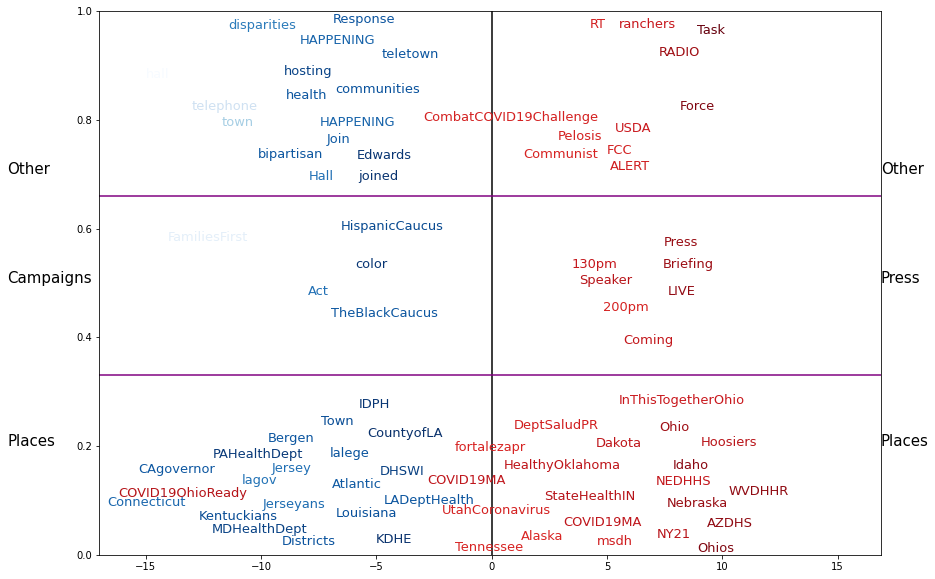

In [268]:
plot_logodds(result,  month='All', num_words=40)